In [1]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import mean_squared_error

## Transformada de Fourier

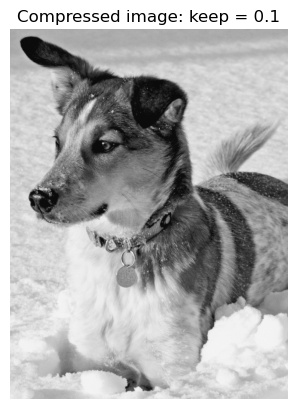

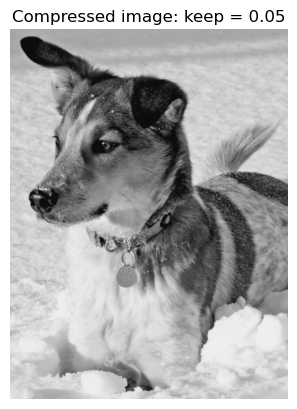

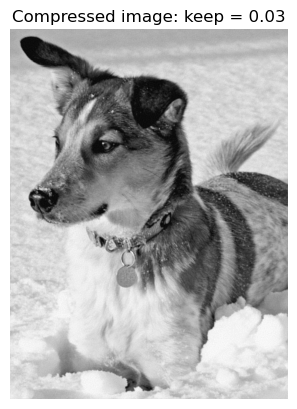

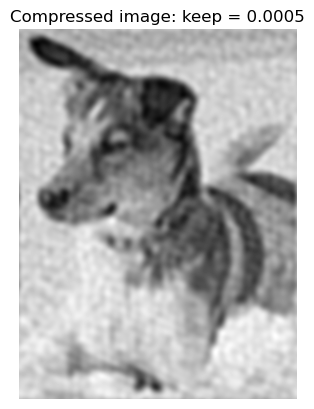

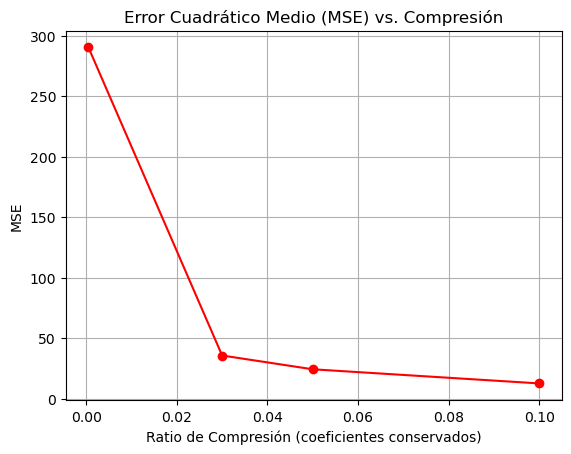

In [2]:
#1.
A = imread(os.path.join('dog.jpg'))
B = np.mean(A, -1); # Convertir la imagen a escala de grises
Bt = np.fft.fft2(B)
Btsort = np.sort(np.abs(Bt.reshape(-1))) # sort by magnitude
error=[]
radios=(0.1, 0.05, 0.03, 0.0005)
# Zero out all small coefficients and inverse transform
for keep in radios:
    thresh = Btsort[int(np.floor((1-keep)*len(Btsort)))]
    ind = np.abs(Bt)>thresh          # Find small indices
    Atlow = Bt * ind                 # Threshold small indices
    comprimida = np.fft.ifft2(Atlow).real  # Compressed image
    error_im=mean_squared_error(B,comprimida)
    error.append(error_im)
    plt.figure()
    plt.imshow(comprimida,cmap='gray')
    plt.axis('off')
    plt.title('Compressed image: keep = ' + str(keep))
# Gráfica de MSE
plt.figure()
plt.plot(radios, error, 'r-o')
plt.xlabel('Ratio de Compresión (coeficientes conservados)')
plt.ylabel('MSE')
plt.title('Error Cuadrático Medio (MSE) vs. Compresión')
plt.grid()

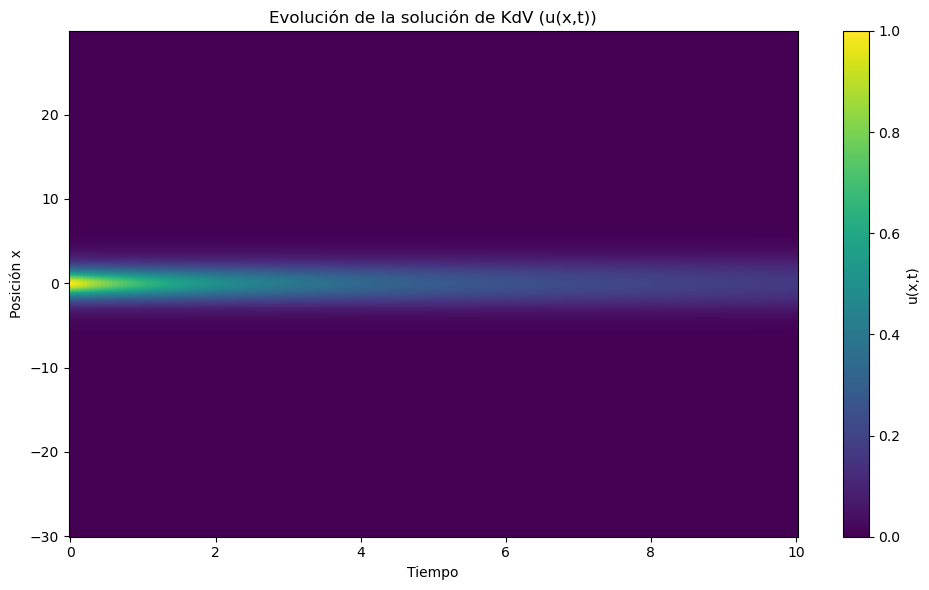

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def resolver_kdv(N=512, L=60.0, dt=0.01, tmax=5.0, nplots=100):
    dx = L / N
    x = np.linspace(-L/2, L/2 - dx, N)  # Dominio espacial

    # Frecuencias para derivadas en el dominio de Fourier
    k = (2 * np.pi / L) * np.fft.fftfreq(N)
    ik = 1j * k
    ik3 = ik**3

    # Condición inicial: pulso tipo sech(x)
    u0 = 1.0 / np.cosh(x)
    u_hat = np.fft.fft(u0)  # Pasamos al dominio de Fourier

    nsteps = int(np.ceil(tmax / dt))  # Número de pasos de tiempo
    plot_intervalo = max(1, nsteps // nplots)

    ts = []
    usol = []

    def termino_lineal(u_hat):
        return -ik3 * u_hat

    def termino_no_lineal(u):
        u_x = np.fft.ifft(ik * np.fft.fft(u)).real
        return -0.5 * np.fft.fft(u**2)

    # Inicializar evolución temporal
    u_hat_actual = u_hat.copy()
    t = 0.0

    for paso in range(nsteps + 1):
        if paso % plot_intervalo == 0:
            u = np.fft.ifft(u_hat_actual).real
            ts.append(t)
            usol.append(u)

        # Método de Runge-Kutta 4 (RK4)
        u = np.fft.ifft(u_hat_actual).real
        k1 = termino_lineal(u_hat_actual) + termino_no_lineal(u)

        u_hat2 = u_hat_actual + 0.5 * dt * k1
        u2 = np.fft.ifft(u_hat2).real
        k2 = termino_lineal(u_hat2) + termino_no_lineal(u2)

        u_hat3 = u_hat_actual + 0.5 * dt * k2
        u3 = np.fft.ifft(u_hat3).real
        k3 = termino_lineal(u_hat3) + termino_no_lineal(u3)

        u_hat4 = u_hat_actual + dt * k3
        u4 = np.fft.ifft(u_hat4).real
        k4 = termino_lineal(u_hat4) + termino_no_lineal(u4)

        u_hat_actual += (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t += dt

    return x, np.array(ts), np.array(usol)


def main():
    x, ts, usol = resolver_kdv(N=512, L=60.0, dt=0.005, tmax=10.0, nplots=200)

    # Graficar la evolución de la solución como un mapa de calor
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(ts, x, usol.T, shading='auto', cmap='viridis')
    plt.xlabel('Tiempo')
    plt.ylabel('Posición x')
    plt.title('Evolución de la solución de KdV (u(x,t))')
    plt.colorbar(label='u(x,t)')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()


## Sparsity and Compressed Sensing

Reconstrucción 30% - Min: 0.000, Max: 0.834
Reconstrucción 45% - Min: 0.000, Max: 0.784
Reconstrucción 80% - Min: 0.000, Max: 0.727


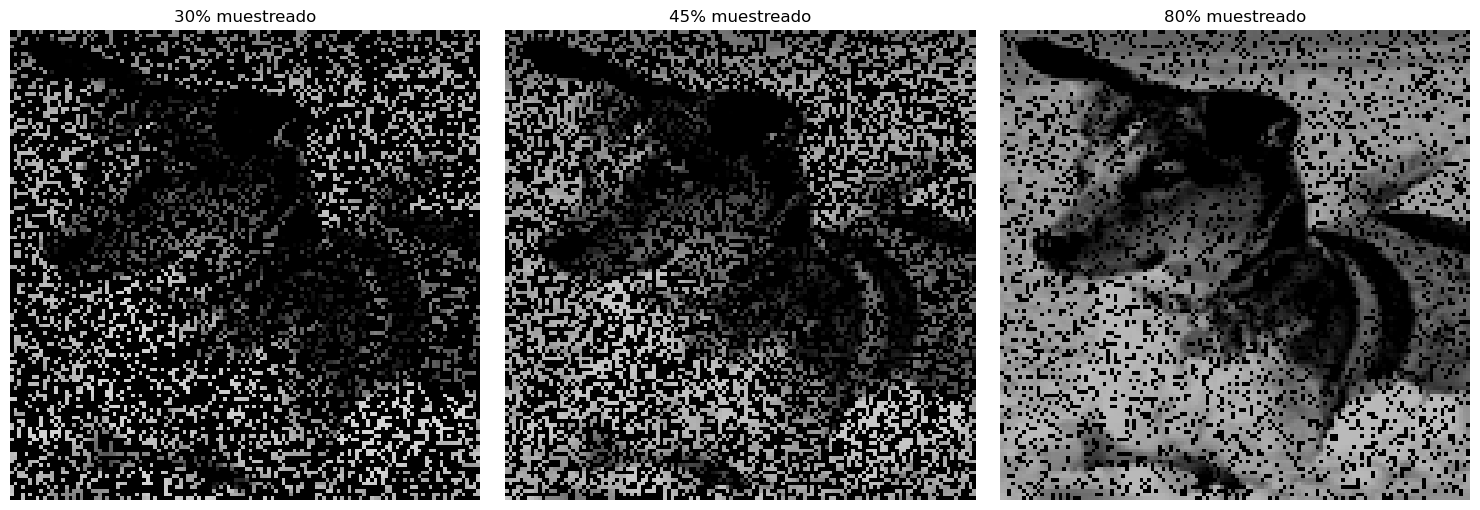

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import sparse
from sklearn.linear_model import Lasso

# 1. Cargar imagen
img = Image.open('dog.jpg').convert('L')
img = img.resize((128, 128))  # Tamaño pequeño para pruebas
img_array = np.array(img) / 255.0

# 2. Función de reconstrucción optimizada
def cs_reconstruction(pct_sample):
    ny, nx = img_array.shape
    mask = np.random.rand(ny, nx) < pct_sample/100
    samples = img_array * mask
    
    # Matriz A dispersa
    rows = np.arange(np.sum(mask))
    cols = np.where(mask.flatten())[0]
    A = sparse.coo_matrix((np.ones_like(rows), (rows, cols)), shape=(np.sum(mask), nx*ny))
    
    # Ajustes clave: Alpha muy pequeño y positive=True
    lasso = Lasso(alpha=0.000001, max_iter=100000, tol=1e-10, positive=True)
    lasso.fit(A, samples[mask].flatten())
    
    reconstructed = lasso.coef_.reshape(ny, nx)
    return np.clip(reconstructed, 0, 1)

# 3. Prueba con porcentajes
pcts = [30, 45, 80]
fig, axes = plt.subplots(1, len(pcts), figsize=(15, 5))

for i, pct in enumerate(pcts):
    recon = cs_reconstruction(pct)
    print(f"Reconstrucción {pct}% - Min: {np.min(recon):.3f}, Max: {np.max(recon):.3f}")
    
    axes[i].imshow(recon, cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f'{pct}% muestreado')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Regresión y selección de modelo

/opt/anaconda3/envs/juliodolores/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+01, tolerance: 2.145e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/juliodolores/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.69621e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/envs/juliodolores/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.197e+01, tolerance: 2.145e-01
  model = cd_fast.enet_coordinate_descent(


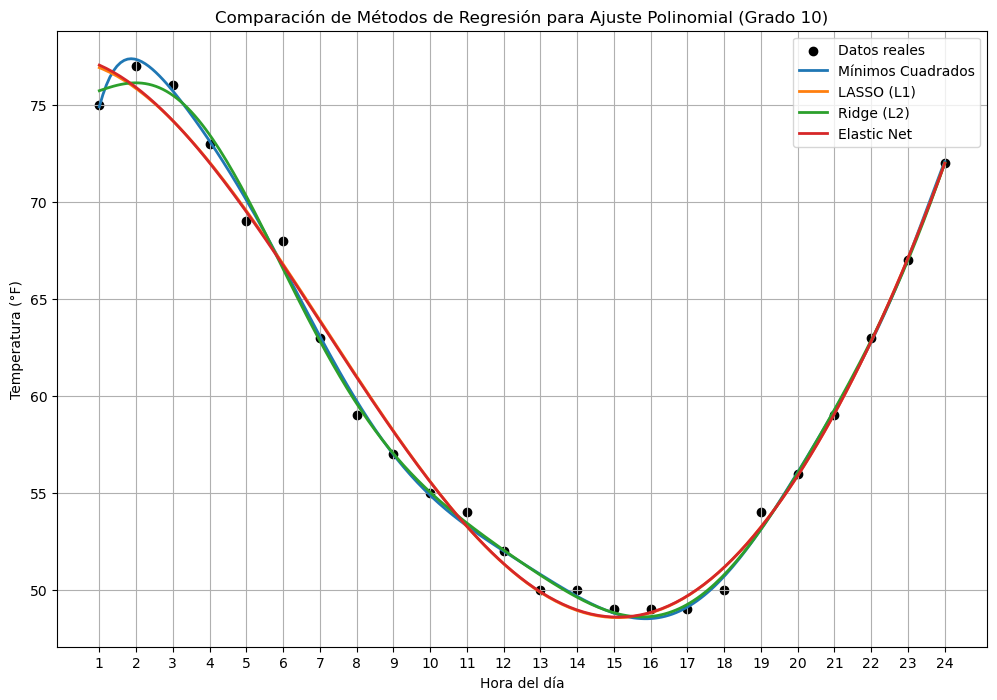

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import make_pipeline

# Datos de temperatura (hora, temperatura)
datos = [
    (1, 75), (9, 57), (17, 49), (2, 77), (10, 55), (18, 50), 
    (3, 76), (11, 54), (19, 54), (4, 73), (12, 52), (20, 56),
    (5, 69), (13, 50), (21, 59), (6, 68), (14, 50), (22, 63),
    (7, 63), (15, 49), (23, 67), (8, 59), (16, 49), (24, 72)
]

# Separar horas y temperaturas
horas = np.array([d[0] for d in datos]).reshape(-1, 1)
temperaturas = np.array([d[1] for d in datos])


## Minimos cuadrados
modelo_ls = make_pipeline(PolynomialFeatures(10), LinearRegression())
modelo_ls.fit(horas, temperaturas)
horas_plot = np.linspace(1, 24, 240).reshape(-1, 1)
pred_ls = modelo_ls.predict(horas_plot)

## LASSO
modelo_lasso = make_pipeline(PolynomialFeatures(10), Lasso(alpha=0.1, max_iter=10000))
modelo_lasso.fit(horas, temperaturas)
pred_lasso = modelo_lasso.predict(horas_plot)

## RIDGE
modelo_ridge = make_pipeline(PolynomialFeatures(10), Ridge(alpha=1.0))
modelo_ridge.fit(horas, temperaturas)
pred_ridge = modelo_ridge.predict(horas_plot)

## Elastic Net
modelo_enet = make_pipeline(PolynomialFeatures(10), ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000))
modelo_enet.fit(horas, temperaturas)
pred_enet = modelo_enet.predict(horas_plot)


### Grafica
plt.figure(figsize=(12, 8))

# Graficar datos originales
plt.scatter(horas, temperaturas, color='black', label='Datos reales')

# Graficar predicciones
plt.plot(horas_plot, pred_ls, label='Mínimos Cuadrados', linewidth=2)
plt.plot(horas_plot, pred_lasso, label='LASSO (L1)', linewidth=2)
plt.plot(horas_plot, pred_ridge, label='Ridge (L2)', linewidth=2)
plt.plot(horas_plot, pred_enet, label='Elastic Net', linewidth=2)
plt.xlabel('Hora del día')
plt.ylabel('Temperatura (°F)')
plt.title('Comparación de Métodos de Regresión para Ajuste Polinomial (Grado 10)')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(1, 25))
plt.show()


In [6]:
### Comparación 
# Obtener coeficientes de cada modelo
coef_ls = modelo_ls.named_steps['linearregression'].coef_
coef_lasso = modelo_lasso.named_steps['lasso'].coef_
coef_ridge = modelo_ridge.named_steps['ridge'].coef_
coef_enet = modelo_enet.named_steps['elasticnet'].coef_

print("Número de coeficientes no cero:")
print(f"Mínimos cuadrados: {np.sum(coef_ls != 0)}")
print(f"LASSO: {np.sum(coef_lasso != 0)}")
print(f"Ridge: {np.sum(coef_ridge != 0)}")
print(f"Elastic Net: {np.sum(coef_enet != 0)}")

Número de coeficientes no cero:
Mínimos cuadrados: 10
LASSO: 9
Ridge: 10
Elastic Net: 10
